In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Resources

**Books (on Google Drive):**

Introduction to Statistical Learning, chapters 4.1 and 4.2

Hands on Machine Learning with scikit-learn and tensorflow, chapter 2


**Scikit-learn doc:**

https://scikit-learn.org/stable/

https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

https://scikit-learn.org/stable/modules/cross_validation.html


**Other resources:**

https://www.youtube.com/watch?v=UqYde-LULfs

https://neptune.ai/blog/f1-score-accuracy-roc-auc-pr-auc

https://medium.com/30-days-of-machine-learning/day-3-k-nearest-neighbors-and-bias-variance-tradeoff-75f84d515bdb

# Classification with scikit-learn : predicting heart diseases with machine learning

## The Heart disease dataset

For discovering classification, we're gonna use a rather classic dataset: the heart disease dataset. This dataset contains 13 symptoms and other attributes of patients that have been checked for a heart disease, such as their age, their cholesterol blood level, the type of pain they report, .... observed on 303 patients. These 13 attributes are called the *features*. And for each of these patients, we know if they have a heart disease or not: the field called *target* in the dataset. This field is generally called the *classes* of the problem, in this case we have two classes : 0 for healthy patients, and 1 for patients with a heart disease, hence it is called a *binary classification problem*.

As with linear regression, we generally denote the feature matrix by $X$, and the classes with $y$, where, in this dataset:


$$X \in \mathbb{R}^{303 \times 13}, y \in  \{0,1\}^{303}.$$
The goal of classification is to learn a function, or *classifier*, $f$ that approximates the true classes $y$ from the features $X$:


$$y \approx f(X).$$

However as $y$ is categorical in classification problems since it represents different classes, as opposed to a continuous value as in linear regression, we cannot use linear regression for solving these problems, and we need different models. 

Also note that classification is not always binary, and can classify features between more than 2 classes (will not be covered today, but the models that we will use here can be directly used with any number of classes).

To get a better idea of these concepts, read chapter 4.1 and 4.2 from the *Introduction to Statistical Learning* book.

First, let's load the dataset into a pandas DataFrame:

In [2]:
dataset = pd.read_csv('../data/heart.csv')

Let's have a look at the column and content:

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


Here are the 13 features, and the classes assignation column called here *target*. We can see that there is no missing values in the data, so far so good. Their names correspond to the following clinical observations:

|Name |Type |	Description |
|-----|-----|---------------|
|age      |integer | age of patient |
|sex      |integer | 1=male; 0=female |
|cp       |integer | chest pain type: 0=typical angina; 1=atypical angine; 2=non-anginal pain; 3=asymptomatic |
|trestbps |integer | resting blood pressure (mm Hg) |
|chol     |integer | serum cholestrol (mg/dl) |
|fbs      |integer | fasting blood sugar: 1 if > 120 mg/dl; 0 otherwise |
|restecg  |integer | resting electrocardiographic results: 0=normal; 1=having ST-T wave abnormality; 2=showing probable or definite left ventricular hypertrophy |
|thalach  |integer | maximum heart rate achieved |
|exang    |integer | exercise induced angina: 1=yes; 0=no |
|oldpeak  |float   | ST depression induced by exercise relative to rest |
|slope    |integer | the slope of the peak exercise ST segment: 0=upsloping; 1=flat; 2=downsloping |
|ca       |integer | number of major vessels (0-4) colored by flourosopy |
|thal     |integer | 1=normal; 2=fixed defect; 3=reversable defect |
|target      |integer | predicted attribute; 0=NO HEART DISEASE; 1=HEART DISEASE |

Some of these features have continuous values such as *age* or *chol*, while others are categorical such as *cp* or *slope*. We will see that categorical variables need to be handled differently when preprocessing the data.

This dataset is derived from : https://archive.ics.uci.edu/ml/datasets/Heart+Disease

## Getting into the data

Let's now have a look of the distribution of the values of each columns:

In [4]:
dataset.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.326733,0.455446
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.583020,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,0.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


We can see that the distribution of the features are different: the age vary from 29 to 77, whereas cholesterol rates from 126 to 564. To avoid some features to bias the classifier because they have larger values than others, we will need to center their means to 0 and scale their variance to 1 when preprocessing them.
Let's now plot the histogram of each feature :

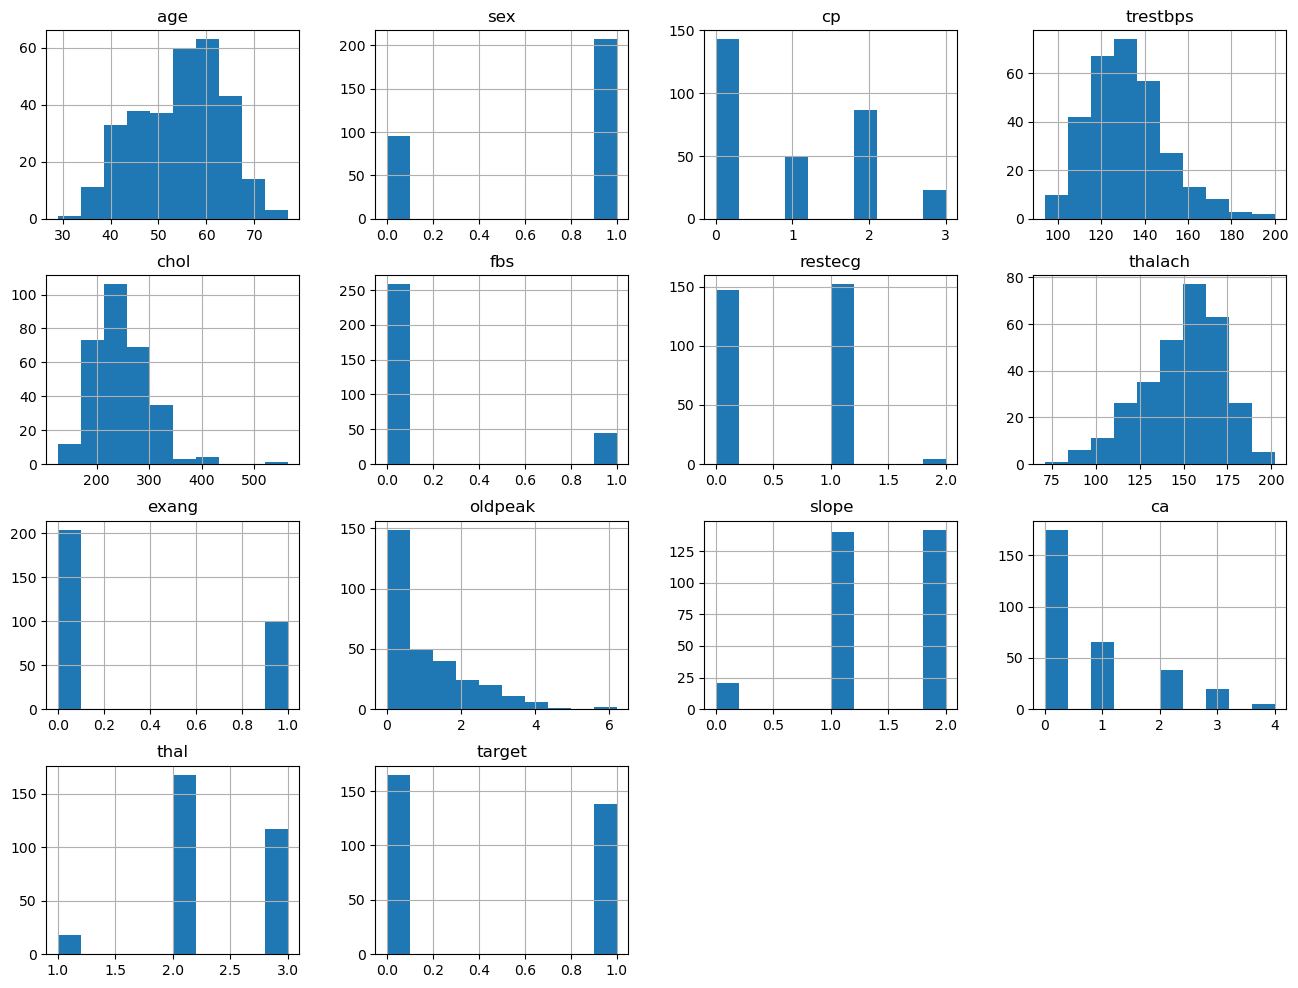

In [5]:
rcParams['figure.figsize'] = 16,12
plots = dataset.hist()

It is quite clear now that some of the features are categorical with peaks only at some value, whereas others are continuous.

Another important thing to check when performing classification is the balance between the target classes: is there as many samples (=patients) that are sick as there are healthy patient:

Text(0.5, 1.0, 'Count of each Target Class')

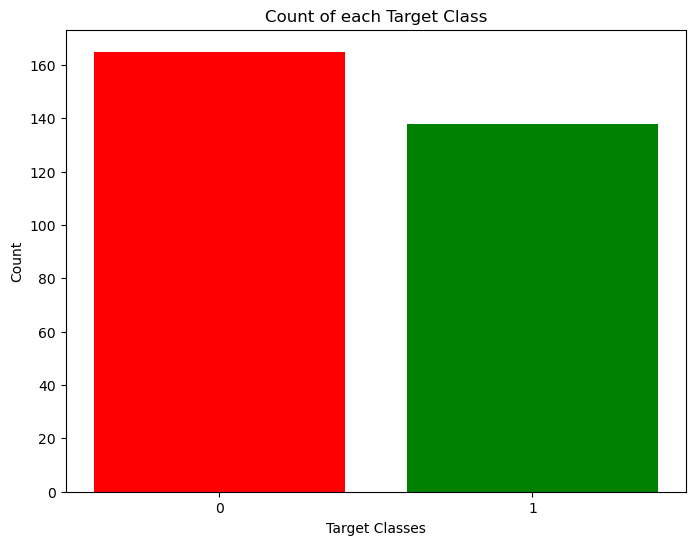

In [6]:
rcParams['figure.figsize'] = 8,6
plt.bar(dataset['target'].unique(), dataset['target'].value_counts(), color = ['red', 'green'])
plt.xticks([0, 1])
plt.xlabel('Target Classes')
plt.ylabel('Count')
plt.title('Count of each Target Class')

A too much imbalanced dataset can bias the classification model towards the class with more samples. Here we see that the two classes, healthy and having a heart diseased, are quite balanced in this dataset. (Some classification models allow for correcting this if needed, you can later have a look at : https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane_unbalanced.html , but we won't need it today).

We can also plot the correlation matrix beween all the features and the target classes to get an idea of which features will probably be good predictors for our problem :

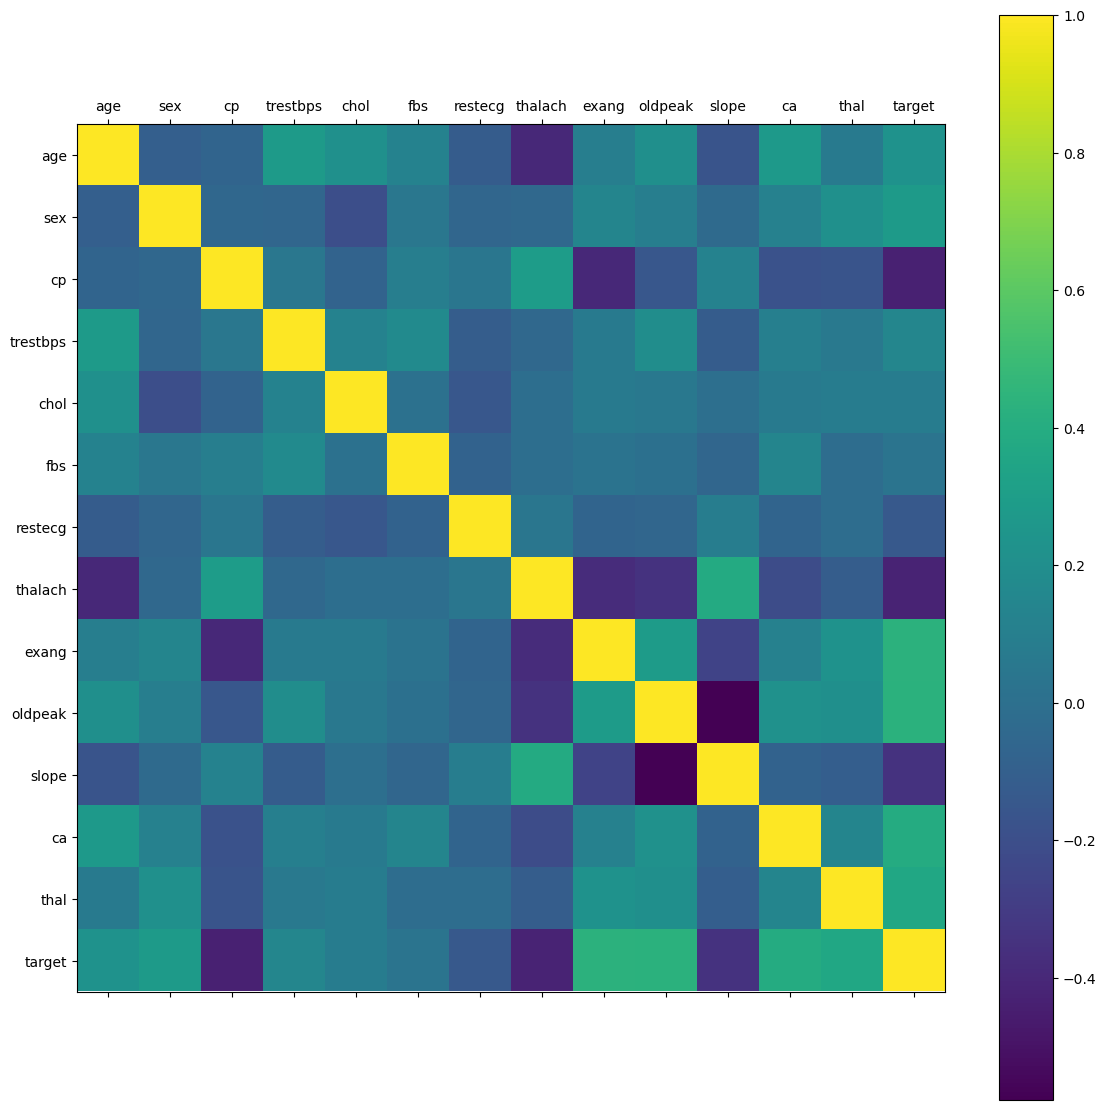

In [7]:
#Some correlate with target, others not
rcParams['figure.figsize'] = 20, 14
plt.matshow(dataset.corr())
plt.yticks(np.arange(dataset.shape[1]), dataset.columns)
plt.xticks(np.arange(dataset.shape[1]), dataset.columns)
plt.colorbar()

/var/folders/cw/t92_wwv10n16x5plcfhdtwxh0000gn/T/ipykernel_16614/319939569.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


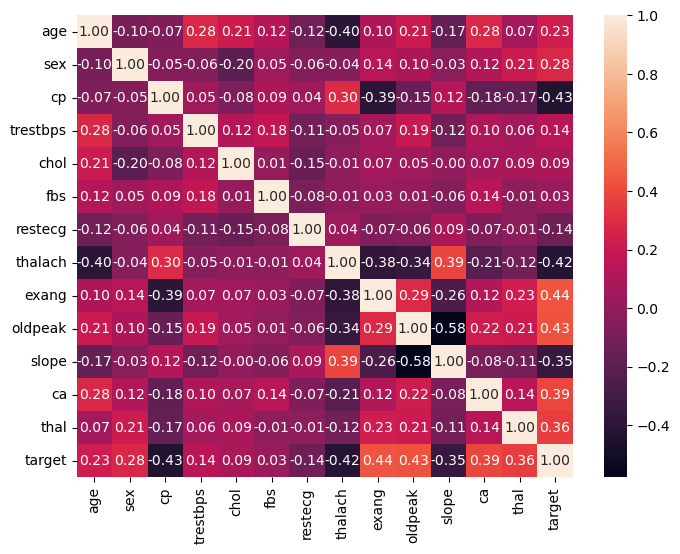

In [8]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(dataset.corr(), annot=True, fmt=".2f", ax=ax)
fig.show()

Here we can see that no single feature has a very high or very low correlation with the target value, meaning that the diagnostic is complex and will require a combination of all of these.

## Preprocessing data

We have seen that we have categorical features, for example the *cp* feature that describes the chest pain type reported with number from 0 to 3:
0=typical angina; 1=atypical angina; 2=non-anginal pain; 3=asymptomatic.

However these are *qualitative* categories, and there is no notion of distance between these numbers: an atypical angina is not 2 times a typical angina! 

To handle that we are going to create what we call *dummy variables*, that is, for each value 0, 1, 2, and 3, we are going to create a new feature which is a 0-1 feature only, and has a 1 value only for its own value. However we will do that only for *multicategorical* features : the ones that have more than two distinct values, since binary features like *sex*, *exang* and *fbs* are already 0-1 features.

In [9]:
multicategorical_features = ['cp', 'restecg', 'slope', 'ca', 'thal']
continuous_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

To create dummy variables, have a look at the get_dummies function from pandas.

In [10]:
dataset = pd.get_dummies(dataset, columns=multicategorical_features, dtype='int')

In [11]:
dataset.columns

Index(['age', 'sex', 'trestbps', 'chol', 'fbs', 'thalach', 'exang', 'oldpeak',
       'target', 'cp_0', 'cp_1', 'cp_2', 'cp_3', 'restecg_0', 'restecg_1',
       'restecg_2', 'slope_0', 'slope_1', 'slope_2', 'ca_0', 'ca_1', 'ca_2',
       'ca_3', 'ca_4', 'thal_1', 'thal_2', 'thal_3'],
      dtype='object')

Let's now plot our new features to see the difference:

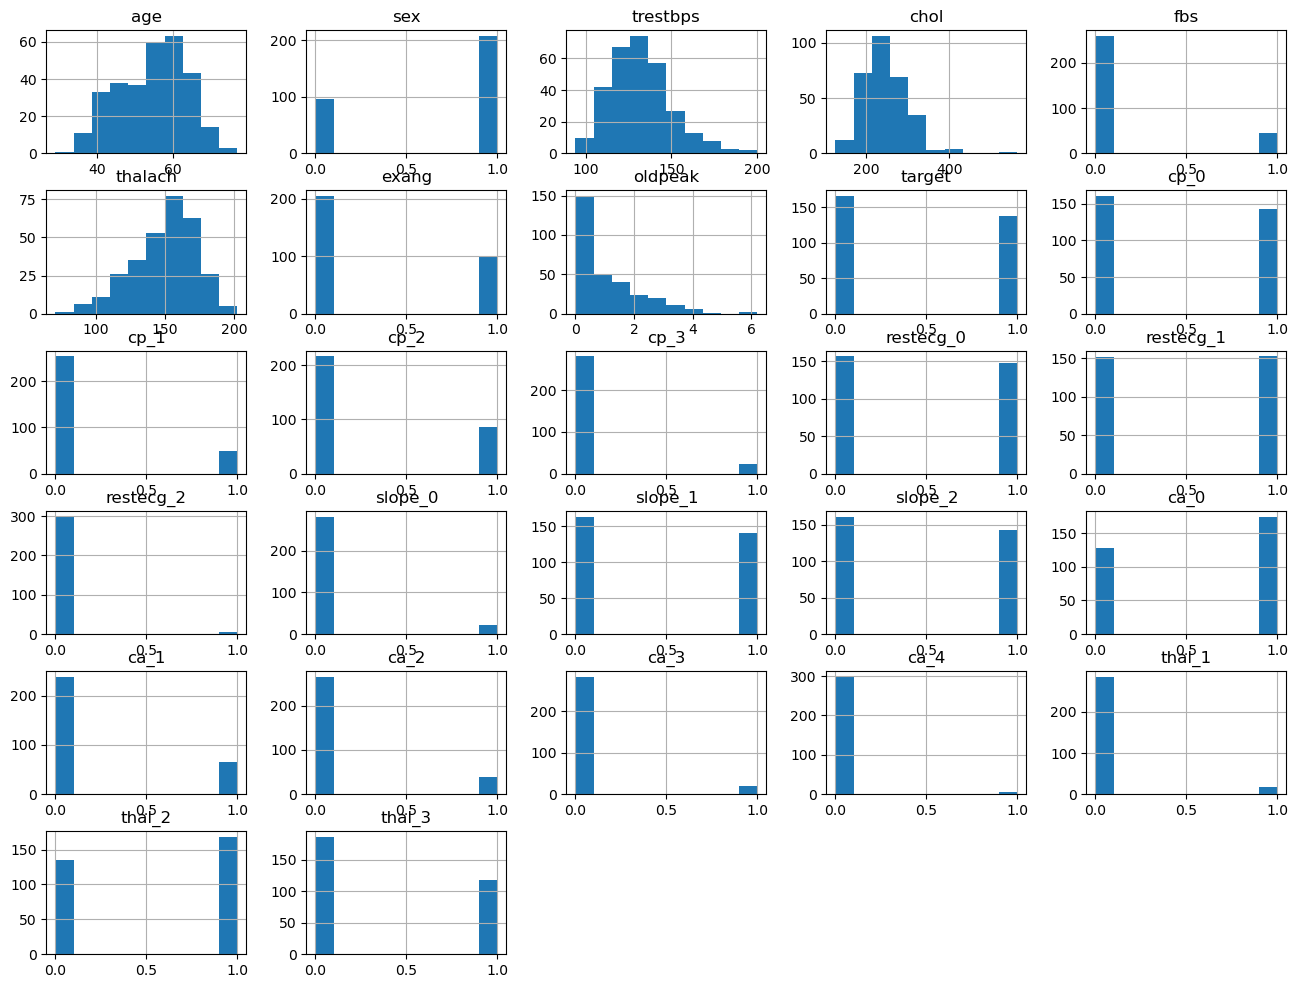

In [12]:
rcParams['figure.figsize'] = 16,12
plots = dataset.hist()

Let's now separate the features from the classes in an $X$ and $y$ variables:

In [13]:
dataset.columns

Index(['age', 'sex', 'trestbps', 'chol', 'fbs', 'thalach', 'exang', 'oldpeak',
       'target', 'cp_0', 'cp_1', 'cp_2', 'cp_3', 'restecg_0', 'restecg_1',
       'restecg_2', 'slope_0', 'slope_1', 'slope_2', 'ca_0', 'ca_1', 'ca_2',
       'ca_3', 'ca_4', 'thal_1', 'thal_2', 'thal_3'],
      dtype='object')

In [14]:
#TO FILL
#Separate features and target 
y_col = 'target'
y = dataset[y_col]
X = dataset.drop(y_col, axis=1)

We've also said that we should center and scale our continuous variables to avoid biasing the classification model, use the *StandardScaler* class from scikit-learn to do so, after splitting the data set between train and test, to fit the scaler on the train set only :

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#Split with a 30% test set, we stratify so that we have the same rate of positives
#in the training and test sets (as well as the same sex ratio, it will be useful at the end of the notebook)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 41, 
                                                    test_size = 0.3, 
                                                    stratify = pd.concat([dataset['sex'], y], axis = 1))

#Scaling continuous variables
scaler = StandardScaler()
scaler.fit(X_train[continuous_features])

#TOFILL 
X_train[continuous_features] = scaler.transform(X_train[continuous_features])
X_test[continuous_features] = scaler.transform(X_test[continuous_features])

X_train_scaled = X_train
X_test_scaled = X_test

Fill the memo.txt file to answer the following question:

1) What are the necessary preprocessing steps regarding:

a) classes: Check to make sure that there are approximately the same number of classes in the dataset. If the size of the classes is not balanced, here is a method that can be used: https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane_unbalanced.html 

b) categorical features: Categorical features that only have two features (ex: 0 and 1) can be left as is. Features with multiple categories can be separated into different columns where each category has its own row using pd.get_dummies(dataset, columns=multicategorical_features, dtype='int')

c) continuous features: Continuous features must be standardized and this can be done using StandardScalar(). Note: the StandardScalar is fit only to the training data

## Classification with k-nearest neighbors, and classification metrics

One easy introduction to classification is to start with the k-neareast neighbors method (KNN). At training, it simply memorizes all the training samples features $X$ and classes $y$. At test time given the features of one sample $x'$, it identifies the $k$ training samples $x_i, i \in 1,\dots,k$ that are the closest to $x'$ (in euclidian distance), and assign the class $y'$ that is the most frequent among the k-neareast neighbor classes $y_i, i \in 1,\dots,k$.

So each test sample is assigned a probablity, for example of having a heart disease:


$$P(y' = 1 ) = \frac{1}{k} \sum_{ i \in 1,\dots,k} \mathbb{1}(y_i = 1) $$
    
where the indicator function $\mathbb{1}(y_i = 1) = 1$ if $y_i = 1$, else $\mathbb{1}(y_i = 1) = 0$. So the probability of having a heart disease is the proportion of the k-nearest train samples that have a heart disease.

For an intuitive explanation of KNNs, watch the first 1:45min of this vid (the rest of it that is about Voronoi partitions is not necessary): https://www.youtube.com/watch?v=UqYde-LULfs

You can also read pages 38-40 from the *Introduction to Statistical Learning*.

Compute the predictions of a k-nearest neighbors classifier on the test set, with k=15 :

In [18]:
from sklearn.neighbors import KNeighborsClassifier

n_neighbors = 15

#TOFILL: 
knn_clf = KNeighborsClassifier(n_neighbors=n_neighbors)
knn_clf.fit(X_train, y_train)

y_test_pred = knn_clf.predict(X_test)

Use these predictions to compute the accuracy of your 15-nearest neighbors model :

In [22]:
from sklearn.metrics import accuracy_score

#TOFILL
accuracy = accuracy_score(y_test, y_test_pred)
print(f'Accuracy: {round(accuracy*100, 4)}%')

Accuracy: 81.3187%


$\approx$ 81%, pretty good for someone who doesn't know about medicine ! However accuracy is a quite limited view of the prediction abilities of your classifier. Indeed it doesn't make the difference between patients that have been incorrectly classified with a heart disease (because they were healthy) with patients that have been incorrectly classified as healthy (because they had a disease).

Let's look at the *confusion matrix* of the prediction, it gives use the number of patients that have been correctly classified as having a disease : the *true positives* (TP) ; the number of patients that have been correctly classified as not having a disease : the *true negatives* (TN); the number of patients that have been incorrectly classified as having a disease : the *false positives* (FP) ; and the number of patients that have been incorrectly classified as nothaving a disease : the *false negatives* (FN). To remember more easily, remark that the true/false refers to the *true* class of the test samples, whereas the positive/negative refers to the *predicted* class by the classifier.

The confusion matrix gives these four numbers in the following format:

|  |  |
|--|--|
|TN|FP|
|FN|TP|

The accuracy is computed by :


$$accuracy= \frac{TP + TN}{TP + TN + FP + FN}$$

One can also look at the accuracy of positive predictions, called the *precision*:


$$precision= \frac{TP }{TP + FP}$$

Or at the ratio of positive samples correctly detected by the classifier, called the *recall*:


$$recall= \frac{TP }{TP + FN}$$
     

These two metrics are often grouped together as a single one called the *f1-measure*:

$$F1=  2 \times \frac{precision \times recall}{precision + recall}$$

You can read more about it in chapter 3 of the book *Hands on Machine Learning with scikit-learn and tensorflow*.

So these metrics gives use different informations about our classifier predictive performances, we are gonna see in more details how below, first compute them on the results of your predictions :

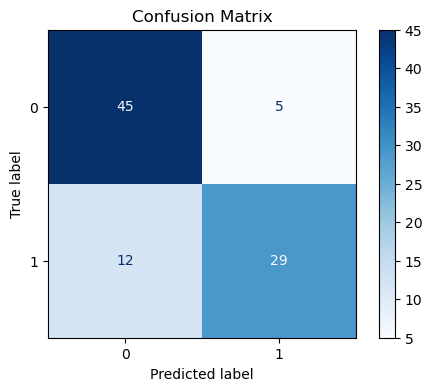

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#TOFILL
cm = confusion_matrix(y_test, y_test_pred, labels=knn_clf.classes_)

fig, ax = plt.subplots(figsize=(6,4))
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred,
                                        display_labels=knn_clf.classes_, 
                                        cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix')
plt.show()

In [45]:
tn, fp, fn, tp = cm.ravel().tolist()
(tn, fp, fn, tp)

(45, 5, 12, 29)

In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

accuracy = accuracy_score(y_test, y_test_pred)
print('Accuracy score:', accuracy)
precision = precision_score(y_test, y_test_pred)
print('Precision score:', precision)
recall = recall_score(y_test, y_test_pred)
print('Recall score:', recall)
f1 = f1_score(y_test, y_test_pred)
print('F1 score:', f1)

Accuracy score: 0.8131868131868132
Precision score: 0.8529411764705882
Recall score: 0.7073170731707317
F1 score: 0.7733333333333333


Fill the memo.txt file to answer these questions:

2)a) How many patient were incorrectly diagnosed with a Heart disease ? 5

2)b) How many patient were incorrectly diagnosed as being Healthy ? 12

In general, remember that accuracy is more sensitive to class imbalance (which is not the case here as there is roughly as many positive as negative samples in the data), and that the f1 better summarizes balance between precision and recall. The f1 is preferred to accuracy when you care more about the positive class (which is our case).

## The precision/recall trade-off

We have assessed some measures that are applicables to the predicted classes, i.e. 0 or 1. Remember that KNN assigns a probability to each test sample, and simply predicts 1 if this probability is higher than > 0.5:


$$P(y' = 1 ) = \frac{1}{k} \sum_{ i \in 1,\dots,k} \mathbb{1}(y_i = 1)  > 0.5$$


Let us say we are here performing a first diagnosis test with our classifier, for further medical investigation if the prediction is positive. In this context, it is much more important to not say someone is healthy if he is not, rather than saying someone is sick if he is not (which can be discovered with later medical tests). In other words, we want to have a few false negatives, even if that implies having more false positives. This means we'd prefer to have a higher Recall, to the cost of having a lower Precision. And that implies choosing a threshold that is lower than 0.5 for assigning the classes.


Use *predict_proba* to get the probability of each test sample, and print these probabilities:

In [46]:
#TOFILL
#Print the probability associated with y:
y_test_proba = knn_clf.predict_proba(X_test)

`y_test_proba` should be a vector of probabilities of being positive of all samples, now let's check that if we apply a 0.5 threshold, we obtain the same predictions as before:

In [51]:
#By default KNN applies a 0.5 threshold to make its predictions:
((y_test_proba[:,1] > 0.5).astype(int) == y_test_pred).all()

np.True_

Let's plot the different values of Precision and Recall for different thresholds:

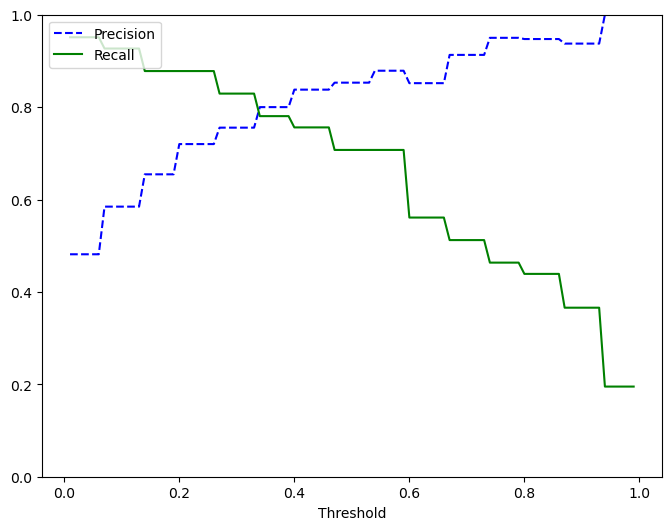

In [93]:
#Precision recall tradeoff
from sklearn.metrics import precision_recall_curve

rcParams['figure.figsize'] = 8, 6
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions, "b--", label="Precision")
    plt.plot(thresholds, recalls, "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

#TOFILL
thresholds = np.arange(1,100) * 0.01
precisions = []
recalls = []
for thresh in thresholds:
    precisions.append(precision_score(y_test, (y_test_proba[:,1] > thresh).astype(int)))
    recalls.append(recall_score(y_test,(y_test_proba[:,1] > thresh).astype(int)))

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

As we can see, the lower the probability threshold, the higher the recall and the lower the precision. There is always a cost: this is what is called the precision/recall tradeoff. A classic way of seeing that is to plot the so-called precision-recall curve, with recall as abcissa and precision in ordinate. Plot it :

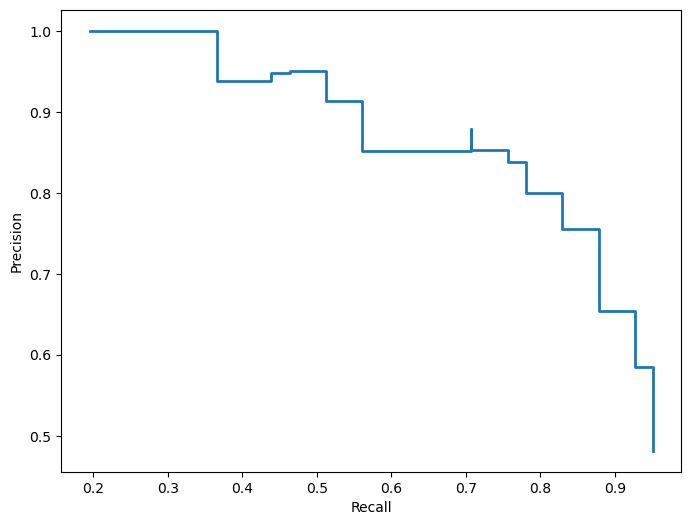

In [72]:
def plot_precision_recall_curve(precisions, recalls):
    plt.step(recalls, precisions, linewidth=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    
#TOFILL
plot_precision_recall_curve(precisions, recalls)

Here again, we can see the precision/recall trade-off. The better the classifier is, the closer the curve will be to the top-right corner. One way to summarize all these trade-offs in a single metric is to compute the area under the precision-recall curve, also called the *average precision* :

In [97]:
from sklearn.metrics import average_precision_score

#TOFILL
average_precision_score(y_test, y_test_proba[:,1])

0.8569688081636231

The average precision is generally the preferred metric if you can compute your test samples probabiliies, and if you care more about the positive class and/or have an imbalanced dataset.

So, let's not forget we are trying to diagnose people's heart disease. Let's say we are ready to accept to incorrectly label as healthy at most 5% of the patients that have a heart disease (false negatives), i.e. we want a recall of 0.95.
Given the threshold curve above, choose a threshold that approximately yields a recall of 0.95, and recompute the confusion matrix as well as precision:

In [94]:
#TOFILL
threshold = thresholds[5]
# threshold = 0.06666599999999667
# threshold = 0.01
y_cv_pred_95recall = (y_test_proba[:,1] > threshold).astype(int)

accuracy = accuracy_score(y_test, y_cv_pred_95recall)
print('Accuracy score:', accuracy)
precision = precision_score(y_test, y_cv_pred_95recall)
print('Precision score:', precision)
recall = recall_score(y_test, y_cv_pred_95recall)
print('Recall score:', recall)
f1 = f1_score(y_test, y_cv_pred_95recall)
print('F1 score:', f1)

Accuracy score: 0.5164835164835165
Precision score: 0.48148148148148145
Recall score: 0.9512195121951219
F1 score: 0.639344262295082


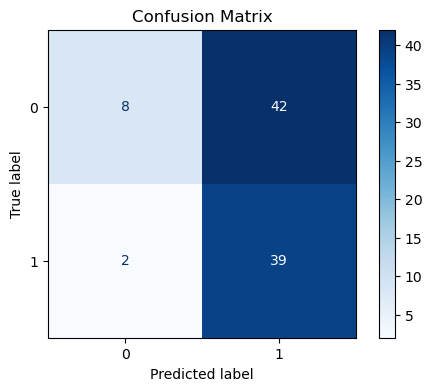

In [90]:
fig, ax = plt.subplots(figsize=(6,4))
ConfusionMatrixDisplay.from_predictions(y_test, y_cv_pred_95recall,
                                        display_labels=knn_clf.classes_, 
                                        cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix')
plt.show()

Fill the memo.txt file to answer these two questions:

3)a)What is the precision if we change the threshold to have a 0.95 recall ? 0.48148148148148145

b) How many patient were incorrectly diagnosed as being Healthy (false negatives)? 2

## The Receiver Operating Characteristic (ROC) curve

(Yet) another way to look at your classfier performance, is to consider the false positive rate (FPR) instead of precision:


$$FPR= \frac{FP}{FP + TN}$$

This is the proportion of negative test samples that are incorrectly classified as positive. Plotting the FPR against the recall gives another classic evaluation curve, the ROC curve. 

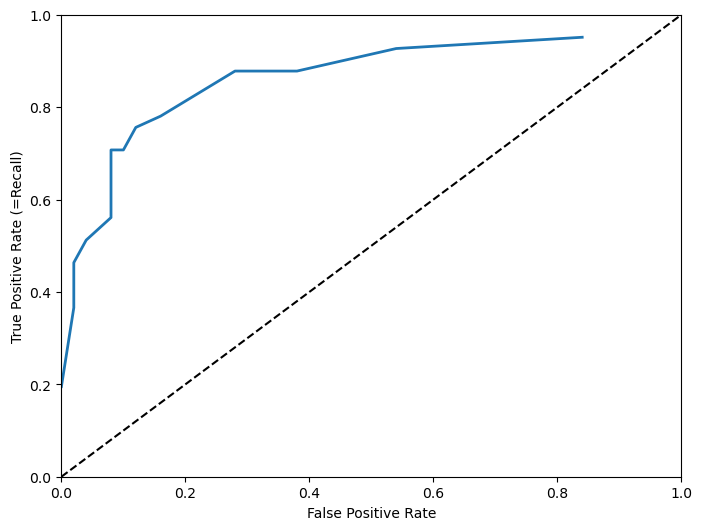

In [100]:
#The ROC curve
from sklearn.metrics import roc_curve

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (=Recall)')

#TOFILL
thresholds = np.arange(1,100) * 0.01
fpr = []
recalls = []
for thresh in thresholds:
    cm = confusion_matrix(y_test, (y_test_proba[:,1] > thresh).astype(int), labels=knn_clf.classes_)
    tn, fp, fn, tp = cm.ravel()
    fpr.append(fp/(fp+tn))
    recalls.append(recall_score(y_test,(y_test_proba[:,1] > thresh).astype(int)))

plot_roc_curve(fpr, recalls)

Here again there is a trade-off between TPR and FPR. Again, we can compute the area under this curve (AUC) :

In [99]:
from sklearn.metrics import roc_auc_score

#TOFILL
roc_auc_score(y_test, y_test_proba[:,1])

0.8658536585365854

The ROC-AUC is useful when you can compute your test samples probabilities and care about how well ranked are your predictions, but it should be used when you have a balanced dataset and care equally about both targets, so we won't use it in the following because we care more about the positive class.

If you want to know more about all classification metrics and when to use them, you can read : https://neptune.ai/blog/f1-score-accuracy-roc-auc-pr-auc

Fill the memo.txt file to answer the following questions:

a) If I can compute my test sample probabilities and care more about the positive class, which overall metric should I use to compare classifiers ? average_precision_score
The average precision is generally the preferred metric if you can compute your test samples probabiliies, and if you care more about the positive class and/or have an imbalanced dataset.

b) And if I only have the class predictions and no probabilities ? F1 score
A high F1 score (generally above 0.7) indicates that the model has a good balance between precision and recall, meaning it can effectively identify positive cases while minimizing false positives and false negatives.

## Hyper-parameters search : the best number of neighbors

Now we know that in our case (we care more about the people who are sick, i.e. the positive class), the best way to compare classifiers with a single metric is *average precision* (AP), so we can start choosing the best hyper-parameter k. You have already studied the bias/variance tradeoff with linear regression. Here this is the same: with k=1 the bias will be 0, but the variance very high, and conversely with too high a k. In both cases, we will have a sub-optimal AP.

You can read more about the bias/variance trade-off with KNNs here: https://medium.com/30-days-of-machine-learning/day-3-k-nearest-neighbors-and-bias-variance-tradeoff-75f84d515bdb


Let's search for the value of k that gives the best AP score, by doing a grid-search as you already did with linear regression, but first lets play a bit with the value of k. As you have already learnt, to choose the best hyper-parameters, we leave the test set aside, and do a *cross-validation* on the train set, from which we can compute *validation metrics* for each hyper-parameter combination to select them. You can remind yourself about cross-validation here:

https://scikit-learn.org/stable/modules/cross_validation.html

Plot the PR curve and compute the mean validation APs with k=15, 30 and 50 by doing a 5-fold cross-validation over the training set :

/Users/fluids/miniconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/fluids/miniconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/fluids/miniconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/fluids/minic

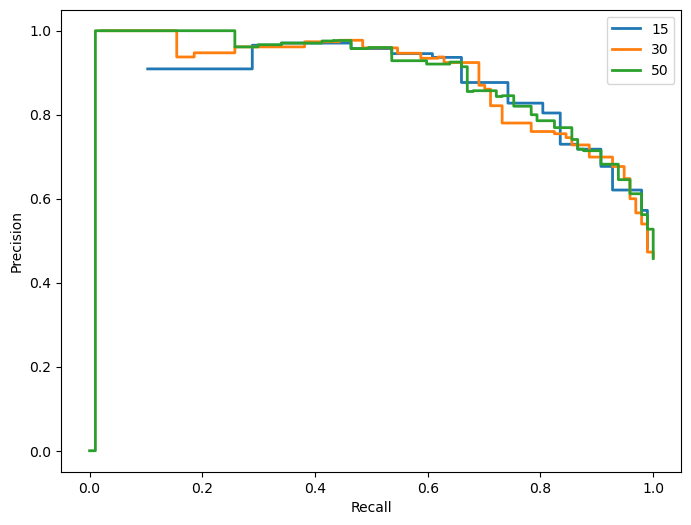

In [109]:
from sklearn.model_selection import cross_val_predict
#TOFILL

def calc_prec_recall(y_train_var, y_train_pred_var, thresholds):
    precisions = []
    recalls = []
    for thresh in thresholds:
        precisions.append(precision_score(y_train_var, (y_train_pred_var>thresh).astype('int')))
        recalls.append(recall_score(y_train_var, (y_train_pred_var>thresh).astype('int')))
    return precisions, recalls

def plot_precision_recall_curve(precisions, recalls, ax, label_knn):
    ax.step(recalls, precisions, linewidth=2, label=label_knn)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')

fig, ax = plt.subplots(figsize=(8,6))

k_vals = [15, 30, 50]
thresholds = np.arange(1,1000) * 0.001

for k_val in k_vals:        
    knn = KNeighborsClassifier(n_neighbors=k_val)
    y_train_pred = cross_val_predict(knn, X_train, y_train, method='predict_proba', cv=5)

    precisions, recalls = calc_prec_recall(y_train, y_train_pred[:,1], thresholds)
    plot_precision_recall_curve(precisions, recalls, ax=ax, label_knn=str(k_val))
    
plt.legend()
plt.show()

In [108]:
thresh

np.float64(0.99)

In [107]:
(y_train_pred[:,1]>thresh).astype('int')

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

To automatically select the k value that yields the best mean validation AP, use the *GridSearchCV* class to perform a grid search by doing a 5-fold cross validation on the train set with k ranging froom 0 to 100, and print the best mean AP on the cross validation and the best k value:

In [ ]:
#Grid search k and give its roc auc score:
from sklearn.model_selection import GridSearchCV

k_range = range(1,101)
param_grid =  {'n_neighbors': k_range}
knn_clf = KNeighborsClassifier()

#TOFILL

Now let's retrain a model with the optimal value of k obtained on the train set, and find a theshold that gives a recall of 0.95 or higher on the test set. Recompute the precision on the test set and compare it to the one you obtained before grid searching for the optimal value of k.

In [ ]:
#TOFILL

## Parity between Men and Women

Our dataset actually contains more men than women. Men are encoded with 1 in the *sex* column, and women with 0. Compute the men/women ratio :

In [ ]:
#TOFILL

This could have the effect of having a model biased towards men, that will have a lower precision and recall on women. Medicine has a long-standing history of gender bias. Not only men have been more numerous in clinical studies, but this also had the effect of delaying diagnosis on women, who hence exhibited different symptoms when diagnosed, which could be another source of bias for our model :

https://theconversation.com/gender-bias-in-medicine-and-medical-research-is-still-putting-womens-health-at-risk-156495

To check this, recompute precision and recall (using the last threshold you obtained to get a 0.95 recall), but separately for the men and the women in the test set :

In [ ]:
#TOFILL

Indeed we can see that both recall and precision are much lower on women !

Learn about bias in machine learning models, the different definitions of parity and how to enforce them by reading the following article :

https://www.labelia.org/en/blog/fairness-in-machine-learning

In our case we want to enforce the equality of Opportunity (= same True Positive Rate, = same Recall), since we don't want to miss more women with a heart disease than men. 

One way to enforce this is to choose a different threshold that yields a Recall > 0.95 for each group (men and women). Find such thresholds :

In [ ]:
#TOFILL

The automation of discrimination through biased machine learning models is a raising concern, there are many resources of interest in the *Bibliography* section of the above article to learn about it. Be sure to check for biases in your future models !

# Going further : Try out other classification models

## Decision Trees 

Decision trees can be very useful when you need to understand how the classifier chooses the classes. You can read more about it there:

https://en.wikipedia.org/wiki/Decision_tree_learning

https://scikit-learn.org/stable/modules/tree.html

Train a decision tree with *max_depth=3*, and use the  sklearn.tree.plot_tree function to visualize it (use the *feature_names* and *class_names* parameters to have useful infos in the tree visualization).

In [ ]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

max_depth = 3

#TOFILL

Grid search over the 'max_depth' parameter and compute the the best ROC-AUC for the decision tree:

In [ ]:
#TOFILL


## Support Vector Machines

In general Support Vector Machines (SVM) is the classification method that often gives the best predictive performances. You can read about it there:

https://scikit-learn.org/stable/modules/svm.html (beginning of section 1.4.7 gives an intuitive view of the principles of SVMs)

Similarly, grid search over the 'C' parameter and compare ROC AUC scores:

In [ ]:
from sklearn.svm import SVC
#TOFILL


SVMs offer the possibility to express complex combinations of the features, through different *kernels*. See:

https://scikit-learn.org/stable/auto_examples/svm/plot_svm_kernels.html

https://towardsdatascience.com/understanding-support-vector-machine-part-2-kernel-trick-mercers-theorem-e1e6848c6c4d

Check the available kernels in scikit-learn, and do a grid-search on kernel types and other hyper-parameters of your choice.

In [ ]:
#TOFILL

## Select the best model among all class of models and their hyper-parameters

Write a function that takes a list of different scikit-learn classifiers, as well as a list of each parameter grid to be searched over each classifier, and a scoring function ; and returns the best classifier along with its best parameters and its score. Finally, test it with KNN, SVM and DecisionTrees, and ensure you get a result that is consistent with the results previously obtained. You can also test with LogisticRegression, another powerful classification model.

In [ ]:
def select_best_model_overall(classifiers_list, param_grids_list, X, y, cv=10, scoring='roc_auc'):
    #TOFILL
    
    return best_classifier, best_parameters, best_score

In [ ]:
#TOFILL